In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from agent import Agent
from collections import deque
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [5]:
# get the trained agents
agent = Agent(state_size = state_size, action_size=action_size, random_seed=1)
agent.actor_local.load_state_dict(torch.load('Weights/checkpoint_Actor.pth', map_location=lambda storage, loc: storage))
agent.critic_local.load_state_dict(torch.load('Weights/checkpoint_Critic.pth', map_location=lambda storage, loc: storage))

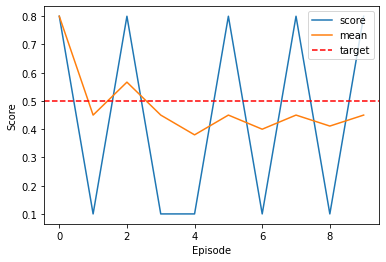

In [6]:
#use trained agent
def maddpg(n_episodes = 10, max_t = 1000):
    scores = []
    means = []
    for episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=False)[brain_name]
        #get the current states
        states = env_info.vector_observations
        #initialize score for one episode
        e_scores = np.zeros(2)
        #reset the agent
        agent.reset()
        for t in range(max_t):
            print(str(t) , end ="\r")
            actions = agent.act(states, noise_factor=0)
            actions_second_player = np.flip(actions, 0)
            #execute the actions
            env_info = env.step(actions)[brain_name] 
            #get the next_states, rewards and informations if episode has finished
            rewards = env_info.rewards
            next_states = env_info.vector_observations
            next_states_second_player = np.flip(next_states, 0)
            dones = env_info.local_done
            #roll over the state
            states = next_states
            #add the reward to the score
            e_scores += rewards
            if np.any(dones):
                break
        #get the maximum score of both agents
        max_score = np.max(e_scores)
        scores.append(max_score)
        means.append(np.mean(scores))
        print("Episode: " + str(episode) + "\tCurrent Score: " + str(round(max_score,3)) + 
              "\tMean over 10 episodes: " + str(round(np.mean(scores),3)), end = "\r")
            
    return scores, means

scores, means = maddpg()

episode_scores = []
for record in scores:
    episode_scores.append(np.mean(record))

#plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(episode_scores)), episode_scores, label = "score")
plt.plot(np.arange(len(means)), means, label = "mean")
plt.axhline(y=0.5, color='r', linestyle='--', label="target")
plt.ylabel('Score')
plt.xlabel('Episode')
plt.legend()
plt.show()

In [7]:
env.close()